<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/classic/strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classic Supervised Machine Learning Strategies

In [0]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%pylab inline

import matplotlib.pyplot as plt
plt.xkcd()

Populating the interactive namespace from numpy and matplotlib


In [0]:
import sklearn
sklearn.__version__

'0.21.2'

## Loading and exploring our data set

This is a database of customers of an insurance company. Each data point is one customer. The group represents the number of accidents the customer has been involved with in the past

* 0 - red: many accidents
* 1 - green: few or no accidents
* 2 - yellow: in the middle        

In [0]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv', sep=';')

In [0]:
df.head()

,speed,age,miles,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


In [0]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000,0.998667
std,17.604333,17.130400,15.250815,0.816768
min,68.000000,16.000000,1.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,100.000000,84.000000,2.000000


In [0]:
y=df['group']

In [0]:
df.drop('group', axis='columns', inplace=True)

In [0]:
X = df.values

### We restrict ourselves to two dimensions for now

Because this is all we really can visualize in 2d

In [0]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter

# https://matplotlib.org/users/colormaps.html
# https://matplotlib.org/gallery/images_contours_and_fields/contourf_demo.html#sphx-glr-gallery-images-contours-and-fields-contourf-demo-py
cmap = ListedColormap(['#FF0000', '#0000FF', '#FFFF00'])

font_size=25
title_font_size=40

def meshGrid(x_data, y_data):
    h = 1  # step size in the mesh
    x_min, x_max = 10, 100
    y_min, y_max = 80, 170
#     x_min, x_max = x_data.min() - 1, x_data.max() + 1
#     y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   size=(15, 8), n_samples=300, proba=True, prediction=True, 
                   legend=False # colab has old version of matplotlib, does not support
                  ):
    xx,yy = meshGrid(x_data, y_data)
    fig, ax = plt.subplots(figsize=size)

    if clf:
        Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])

        if proba:
            probaZ = Z.max(axis=1)
            probaZ = probaZ.reshape(xx.shape)
            ax.contourf(xx, yy, probaZ, cmap=plt.cm.binary, alpha=.4)

        if prediction:
            Z = Z.argmax(axis=1)
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T).sample(n_samples, random_state=42)
    classes = samples[2]
    scatter = ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, s=100, marker='o', edgecolors='k')

    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)

    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html
    formatter = FuncFormatter(lambda s,t: "Many Accidents" if s == 0 else "No Accidents" if s == 1 else "Few Accidents")
    if legend:
      class_legend = ax.legend(*scatter.legend_elements(alpha=0.6, prop='colors', fmt=formatter), title="Classes")
      ax.add_artist(class_legend)
    
    return ax, scatter


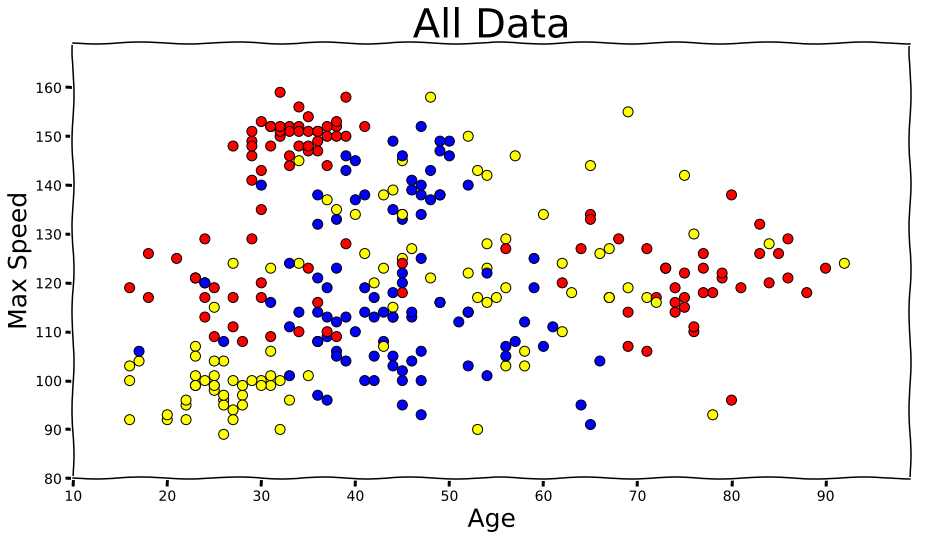

In [0]:
ax, scatter = plotPrediction(None, X[:, 1], X[:, 0], 
               'Age', 'Max Speed', y,
                title="All Data")

## Splitting into test and training data

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1200, 3), (1200,), (300, 3), (300,))

In [0]:
# we have (almost) the same number of samples per categoery 
# in the training...
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([401, 400, 399]))

In [0]:
# ... and test dataset
np.unique(y_test, return_counts=True)

(array([0, 1, 2]), array([100, 100, 100]))

In [0]:
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

(<matplotlib.axes._subplots.AxesSubplot at 0x7f16cda240b8>,
 <matplotlib.collections.PathCollection at 0x7f16cd7b14a8>)

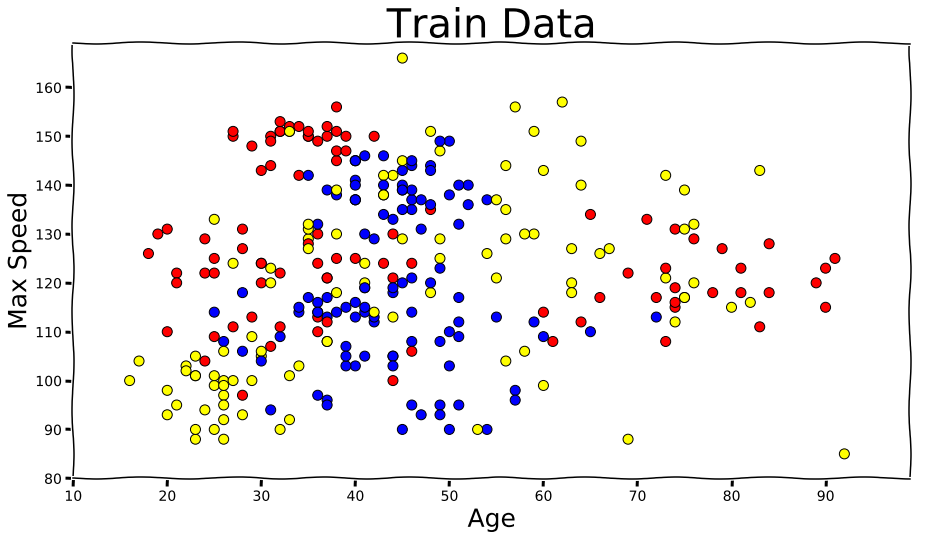

In [0]:
plotPrediction(None, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train, title="Train Data")

(<matplotlib.axes._subplots.AxesSubplot at 0x7f16d569e630>,
 <matplotlib.collections.PathCollection at 0x7f16cd7a02b0>)

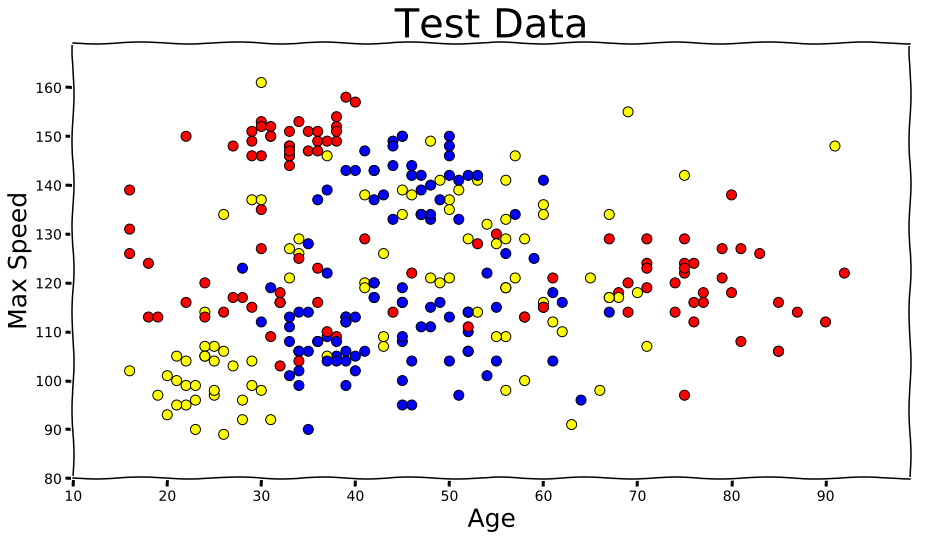

In [0]:
plotPrediction(None, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test, title="Test Data")

# Exercise: Experiment with train/test split

* Execute the notebook up to this point
* change the split ratio between train and test, maybe to 60/40
* change the random seed, why would you want to use it in the first place? is this even a good idea?
* optional: what happens if you do not stratify?


## Overview of most important strategies

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

https://scikit-learn.org/stable/supervised_learning.html

<img src='https://github.com/djcordhose/ml-workshop/blob/master/notebooks/classic/img/clf_comp.png?raw=1'>

* accuracy is plotted
* decision boundaries are plotted as background
* the darker the color the higher the probability

## Gaussian Naive Bayes: Simple, but effective in cases of blobs

https://en.wikipedia.org/wiki/Naive_Bayes_classifier

* _Bayes_: Bayes’ theorem gives a mean to reverse conditional probabilities
* _Naive_: refers to our assumption that all features are independent to simplify the problem
* _Gaussian_: assumption: each category can be described using a Gaussian distribution

How it works
  * Maximum Likelihood Estimation: assuming we have a Gaussian distribution of independent variables which set of parameters has the highest probability of fitting our dataset (https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation)
  * practically is done by computing the mean and the standard deviation from our training data (https://machinelearningmastery.com/naive-bayes-for-machine-learning/, https://towardsdatascience.com/maximum-likelihood-estimation-explained-normal-distribution-6207b322e47f) per category


Features  
  * require a small amount of training data to estimate the necessary parameters
  * fast training
  * probability estimation often is poor
  * allows for online learning

https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [0]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

In [0]:
%%time

clf.fit(X_train_2_dim, y_train)

CPU times: user 2.63 ms, sys: 0 ns, total: 2.63 ms
Wall time: 3.05 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
# you can set set priors explicitly
# clf = GaussianNB(priors=[0.33, 0.33, 0.34])

# based on number of samples per category
clf.class_prior_

array([0.33416667, 0.33333333, 0.3325    ])

In [0]:
clf.class_count_

array([401., 400., 399.])

In [0]:
# mean per category
clf.theta_

array([[130.55860349,  46.27680798],
       [119.83      ,  44.865     ],
       [117.49874687,  43.26566416]])

In [0]:
clf.sigma_

array([[250.40616694, 449.40716818],
       [257.22610031,  77.24177531],
       [328.10964786, 344.32541284]])

In [0]:
input = [[100.0, 48.0], [150.0, 78.0], [100.0, 18.0]]
# should be [1, 0, 2] = [good, bad, mediocre]
clf.predict(input)

array([1, 0, 2])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f16cd6f96a0>,
 <matplotlib.collections.PathCollection at 0x7f16cd6bfcf8>)

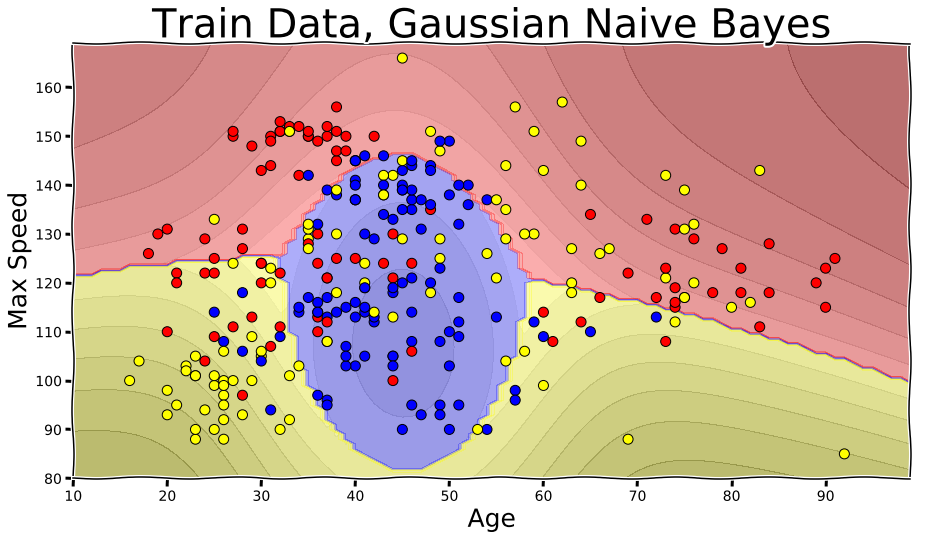

In [0]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Gaussian Naive Bayes")

In [0]:
clf.score(X_train_2_dim, y_train)

0.6083333333333333

(<matplotlib.axes._subplots.AxesSubplot at 0x7f16cd6de208>,
 <matplotlib.collections.PathCollection at 0x7f16cd658080>)

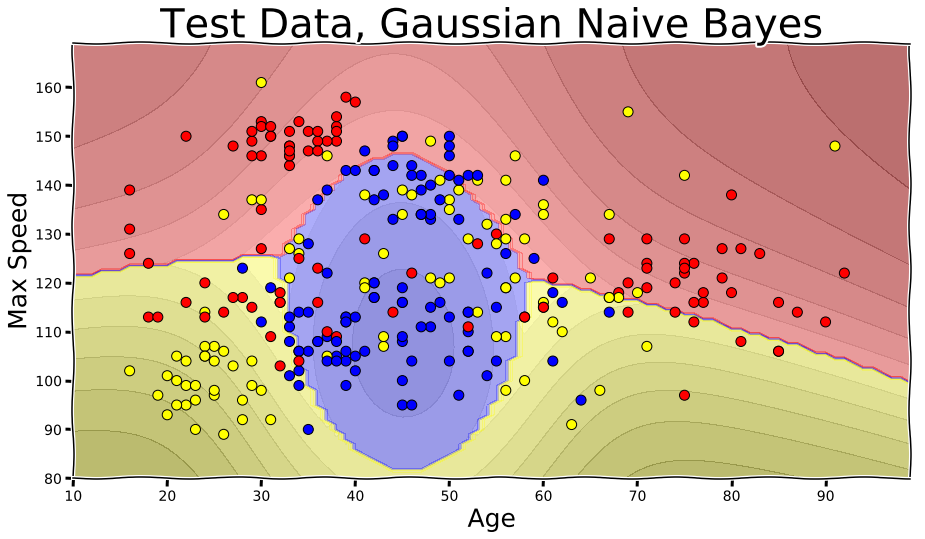

In [0]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Gaussian Naive Bayes")

In [0]:
clf.score(X_test_2_dim, y_test)

0.57

## Cross Validation

Test data for a real problem is sacred. You should not use it to constantly improve your model, but only as a final check that you did not fool yourself.

Cross Validation splits the train data in different ways and performs a number of training runs (3 in this case). It will train using 2 sets and validate on the third. 

http://scikit-learn.org/stable/modules/cross_validation.html

In [0]:
clf = GaussianNB()

In [0]:
from sklearn.model_selection import cross_val_score

In [0]:
scores = cross_val_score(clf, X_train_2_dim, y_train, n_jobs=-1)
scores

array([0.58852868, 0.565     , 0.67669173])

In [0]:
# mean score and the 95% confidence interval (2 standard deviations assuming normal distribution)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.61 (+/- 0.10)


## KNN: Look at the neighbors to make a prediction for a sample yet unknown

https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [0]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(1)

In [0]:
%%time

clf.fit(X_train_2_dim, y_train)

CPU times: user 3.31 ms, sys: 96 µs, total: 3.41 ms
Wall time: 7.33 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f16caac60b8>,
 <matplotlib.collections.PathCollection at 0x7f16caabfcf8>)

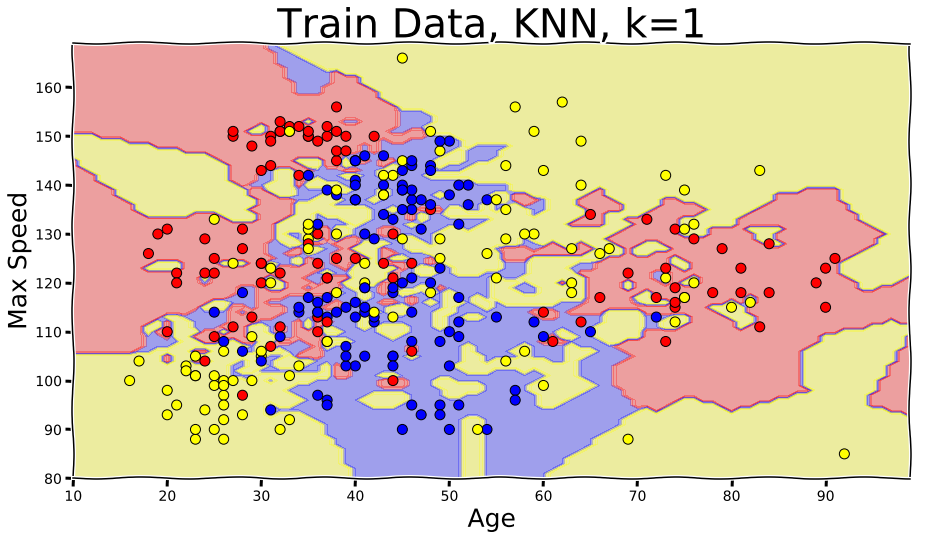

In [0]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, KNN, k=1")

In [0]:
clf.score(X_train_2_dim, y_train)

0.9358333333333333

(<matplotlib.axes._subplots.AxesSubplot at 0x7f16cd5e9cf8>,
 <matplotlib.collections.PathCollection at 0x7f16ca1fee80>)

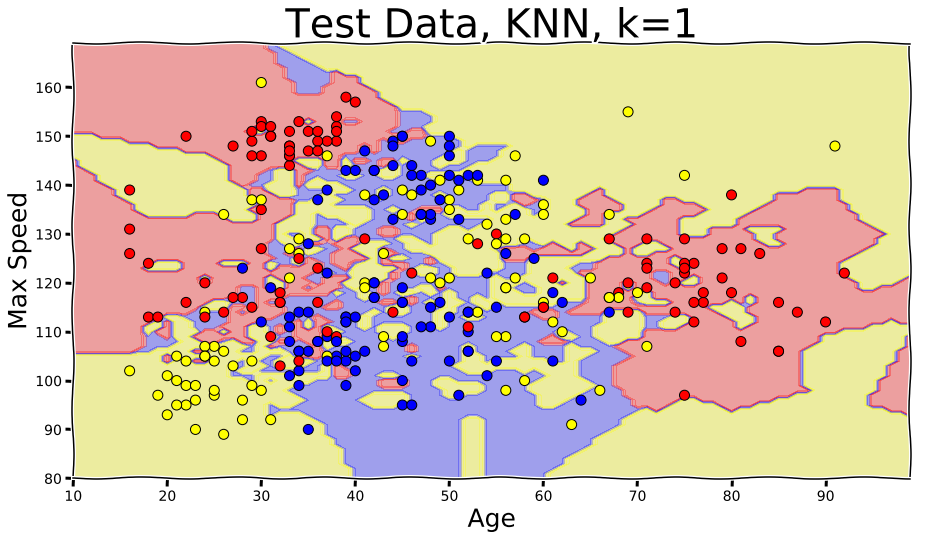

In [0]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, KNN, k=1")

In [0]:
clf.score(X_test_2_dim, y_test)

0.6133333333333333

# Exercise: Fight overfitting in KNN

* the number of neighbors (k) is the most important parameter
* Interactive experiment to see the effect of k: https://beta.observablehq.com/@djcordhose/how-to-build-a-teachable-machine-with-tensorflow-js#knndataset
* rule of thumb: smoother decision boundaries imply less overfitting
* execute the notebook up to this point
* change k based on your previous experiments
* what is the important value to check?

In [0]:
k = 1 # set your k here
clf = KNeighborsClassifier()
clf.fit(X_train_2_dim, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

## Searching for the best parameters

We can try what is the best number of numbers manually, but grid search does the same thing, only with less manual effort. This one tries the number of neighbors between 1 and 50

In [0]:
%%time 

from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_neighbors': list(range(1, 50)),
    'weights': ['uniform', 'distance'] # are points that are nearer more important?
    }
clf = GridSearchCV(KNeighborsClassifier(), param_grid, n_jobs=-1)
clf.fit(X_train_2_dim, y_train)

CPU times: user 205 ms, sys: 10.1 ms, total: 215 ms
Wall time: 2.38 s


In [0]:
clf.best_params_

{'n_neighbors': 14, 'weights': 'uniform'}

In [0]:
%%time 

clf = KNeighborsClassifier(n_neighbors=14, weights='uniform')
clf.fit(X_train_2_dim, y_train)

CPU times: user 2 ms, sys: 311 µs, total: 2.31 ms
Wall time: 4.24 ms


(<matplotlib.axes._subplots.AxesSubplot at 0x7f16ca1bf0f0>,
 <matplotlib.collections.PathCollection at 0x7f16ca0d57b8>)

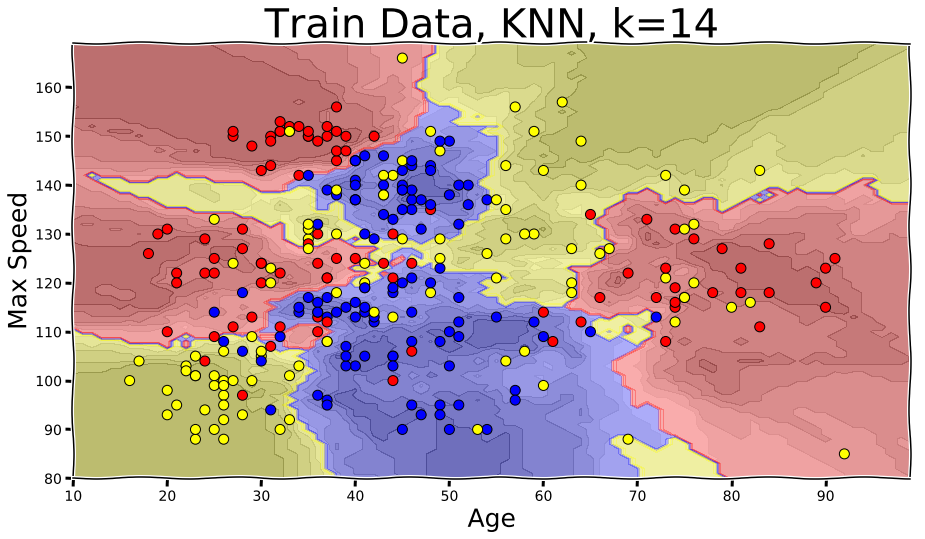

In [0]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, KNN, k=14")

In [0]:
clf.score(X_train_2_dim, y_train)

0.7483333333333333

(<matplotlib.axes._subplots.AxesSubplot at 0x7f16ca1555c0>,
 <matplotlib.collections.PathCollection at 0x7f16ca079748>)

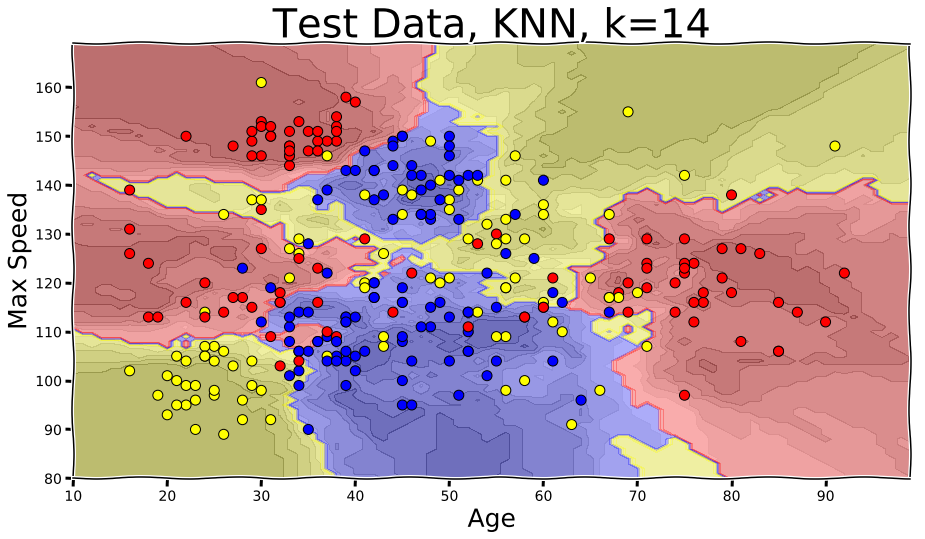

In [0]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, KNN, k=14")

In [0]:
clf.score(X_test_2_dim, y_test)

0.7133333333333334

In [0]:
scores = cross_val_score(clf, X_train_2_dim, y_train, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.71 (+/- 0.04)


# From here on choose you favorite topic

* spend at least one hour working on what you are most interested in
* Work at your one speed
* If you do not have a special interest look at ensemble methods with Random Forst (Sometimes called the Swiss Army Knive for machine learning)
* Ask coaches if you have questions or want to discuss



## Support Vector Machines (SVM)
* SVMs used to be the hot stuff before neural networks stole the show
* SVMs choose a small number of data points to decide where to draw the decision boundary, they are called the *support vectors*

### Linear SVM

In its base version SVMs can only use lines as decision boundaries. Let's see how well this works.

In [0]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', probability=True)
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 3.62 s, sys: 5.38 ms, total: 3.62 s
Wall time: 3.63 s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
clf.score(X_train_2_dim, y_train)

0.4666666666666667

(<matplotlib.axes._subplots.AxesSubplot at 0x7f16ca02e978>,
 <matplotlib.collections.PathCollection at 0x7f16c9f84630>)

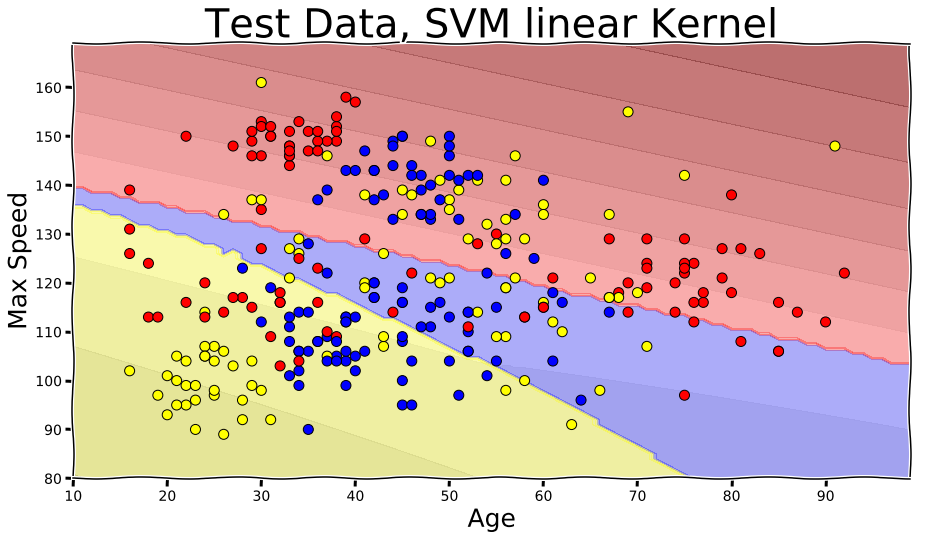

In [0]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, SVM linear Kernel")

In [0]:
clf.score(X_test_2_dim, y_test)

0.43666666666666665

### SVM Kernels

_Kernel Trick allows to solve problems that are not linearly separable_

* As we can see using lines only, we can not even fit the training data, this is called *underfitting*.
* For most realisitic examples we need something better called the 'kernel trick'
* We transform the original problem space into a higher dimension that is separable by lines only
* Radial Base Functions 'rbf' can approximate any function and are trained to perform this transformation (https://en.wikipedia.org/wiki/Radial_basis_function_kernel)

<img src='https://github.com/djcordhose/ml-workshop/blob/master/notebooks/classic/img/svm-kernel-trick.jpg?raw=1'>

Sebastian Thrun for Udacity: https://youtu.be/3Xw6FKYP7e4 


In [0]:
clf = SVC(kernel='rbf', probability=True)
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 496 ms, sys: 0 ns, total: 496 ms
Wall time: 508 ms


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
clf.score(X_train_2_dim, y_train)

0.8841666666666667

(<matplotlib.axes._subplots.AxesSubplot at 0x7f16ca03eda0>,
 <matplotlib.collections.PathCollection at 0x7f16c9e94a58>)

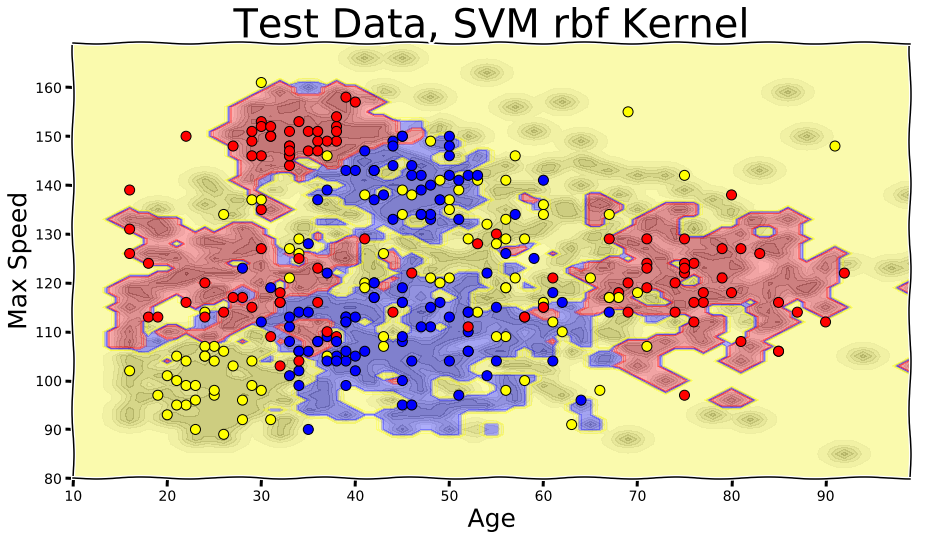

In [0]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, SVM rbf Kernel")

In [0]:
clf.score(X_test_2_dim, y_test)

0.6233333333333333

Again we strongly overfit and need to regularize our model. The two important parameters are
* Gamma
  * reach of a single training sample - low values: far, high values: close
    * https://www.youtube.com/watch?v=m2a2K4lprQw
  * the lower the more points remote from the support vectors influence where the decision boundaries go  
* C (Cost)
  * decides how expensive it is to misclassify one of our support vectors, the smaller the more tolerant to misclassified samples
  * tradeof between smooth decision boundaries and classifying samples correctly
    * https://www.youtube.com/watch?v=joTa_FeMZ2s
    * high cost means rough, complex decision boundaries
    * lower cost means more regularization

Interactively experiment with C and Gamma: https://dash-gallery.plotly.host/dash-svm

http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

In [0]:
param_grid = {
    'C': list(np.append(np.arange(0.1, 1.0, 0.1), np.arange(2, 10, 1))),
    'gamma': list(np.append(np.arange(0.001, 0.1, 0.0005), np.arange(.02, 1.0, 0.1))),
}
clf = GridSearchCV(SVC(), param_grid, n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)
clf.best_params_

CPU times: user 14.9 s, sys: 454 ms, total: 15.3 s
Wall time: 5min 15s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 0.30000000000000004, 'gamma': 0.023}

In [0]:
clf = SVC(kernel='rbf', probability=True, C=0.3, gamma=0.023)
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 264 ms, sys: 1.01 ms, total: 265 ms
Wall time: 268 ms


SVC(C=0.3, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.023, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
clf.score(X_train_2_dim, y_train)

0.7475

(<matplotlib.axes._subplots.AxesSubplot at 0x7f16c9e9e0b8>,
 <matplotlib.collections.PathCollection at 0x7f16c9d5c9e8>)

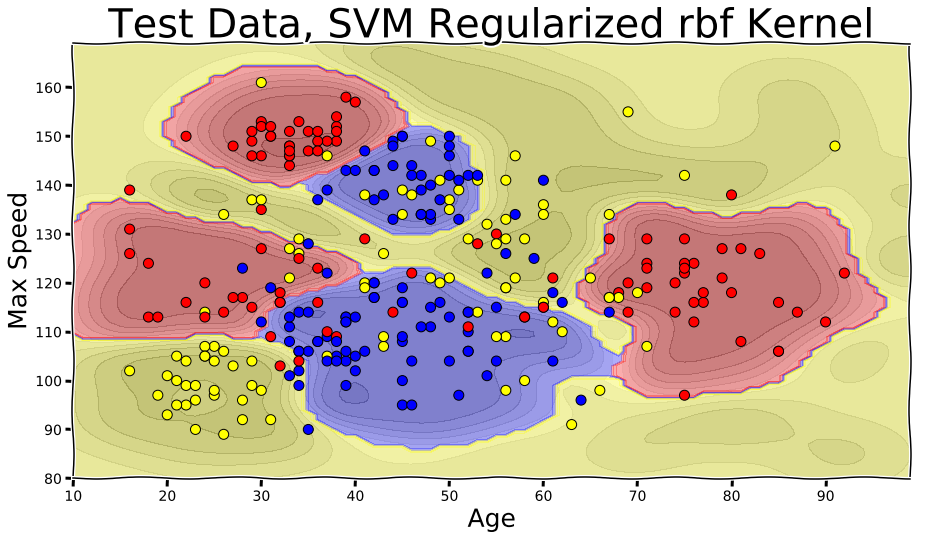

In [0]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, SVM Regularized rbf Kernel")

In [0]:
clf.score(X_test_2_dim, y_test)

0.72

# Optional Exercise: Improve Cost and Gamma
* use https://dash-gallery.plotly.host/dash-svm to get a better intuition for C and Gamma
* Change C and Gamma based on your intuition
* Can you do better than the results coming from the grid search?
* If not: Why not?

## Descision Trees

* Split our data set on a certain variable
* Similar to what we have done in the manual classifier, but here the rules are actually learned

In [0]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 3.01 ms, sys: 0 ns, total: 3.01 ms
Wall time: 3.07 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### How is the Decision Tree being Constructed?

We are using the CART algorithm:
* top-down split the set of examples into two new sets
* choose a variable and a value at each step that best splits our customer example
* terminal node when no further gain possible or regularization kicks in

<img src="https://raw.githubusercontent.com/DJCordhose/ai/master/docs/img/dt/cart.png">

http://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart

### What is the best split?

* choose a feature to split on (either random or best)
* assign a category to each node containing a certain set of samples
* use a metric (Gini or Entropy) to decide how good a node would be based on that category
* sum up weighted metric for both child nodes
* optimize the split for that summed metric

https://machinelearningmastery.com/classification-and-regression-trees-for-machine-learning/

In [0]:
# we perform at most 18 splits of our data until we make a decision where the data point belongs

clf.tree_.max_depth

18

### Complete Decision Tree

<img src="https://github.com/djcordhose/ml-workshop/blob/master/notebooks/classic/img/dt-all.png?raw=1">

(<matplotlib.axes._subplots.AxesSubplot at 0x7f16c9c4a668>,
 <matplotlib.collections.PathCollection at 0x7f16c9888208>)

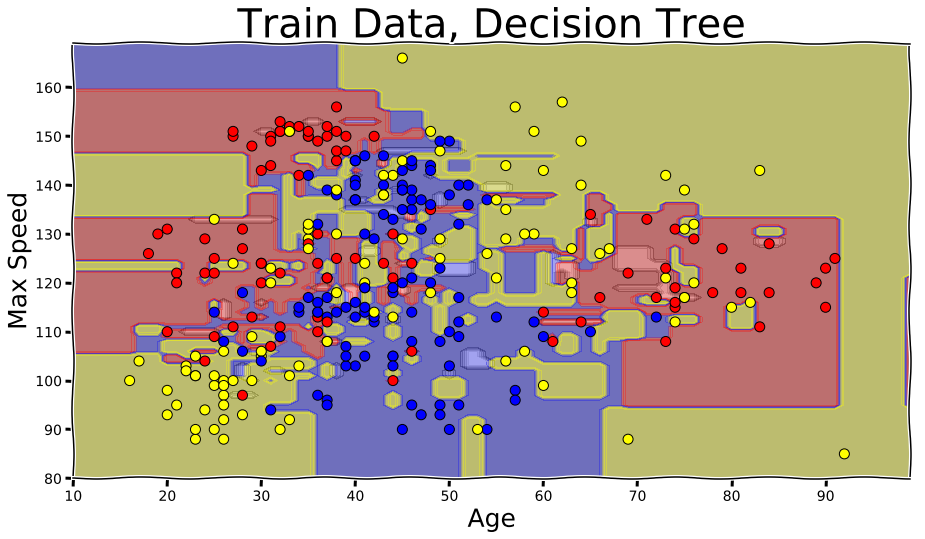

In [0]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Decision Tree")

In [0]:
clf.score(X_train_2_dim, y_train)

0.9425

In [0]:
scores = cross_val_score(clf, X_train_2_dim, y_train, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.61 (+/- 0.07)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f16c98b7208>,
 <matplotlib.collections.PathCollection at 0x7f16c997ceb8>)

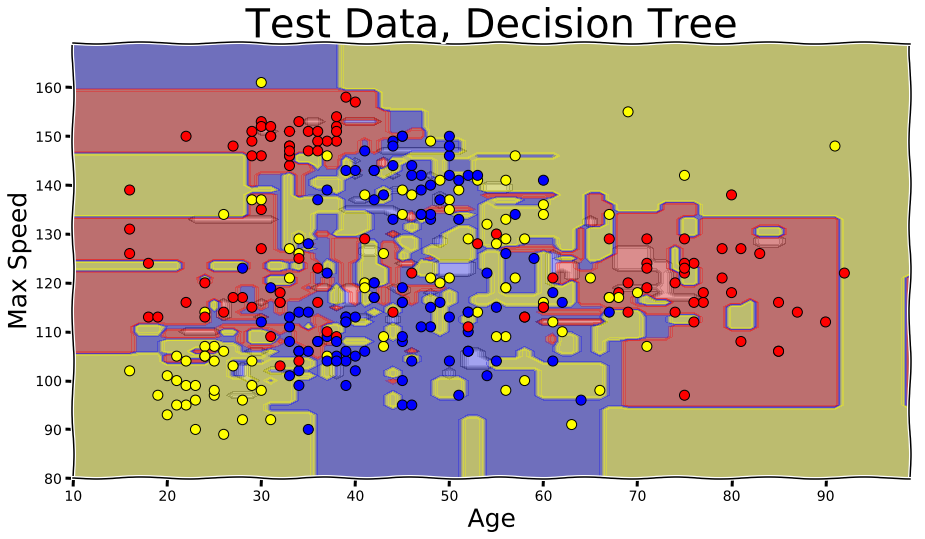

In [0]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Decision Tree")

In [0]:
clf.score(X_test_2_dim, y_test)

0.6066666666666667

We overfit heavily and need to change the relevant parameters of our tree
* its maximum number of splits (depth) - if there is no limit, we can make as many splits as it takes to perfectly match all train data (overfitting)
* how many samples we need at least for a leaf - if it is just one, we could perfectly fit all training data (overfitting)
* how many samples do we need to make another split - not as crucial as the other two, but can still limit overfitting

In [0]:
param_grid = {
    'max_depth': list(range(2, 25)),
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 11))
}
clf = GridSearchCV(DecisionTreeClassifier(), param_grid, n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)
clf.best_params_

CPU times: user 3.32 s, sys: 20.4 ms, total: 3.34 s
Wall time: 11.6 s


{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [0]:
clf = DecisionTreeClassifier(max_depth=6,
                              min_samples_leaf=2,
                              min_samples_split=3)
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 1.39 ms, sys: 2.06 ms, total: 3.45 ms
Wall time: 3.38 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
clf.tree_.max_depth

6

In [0]:
clf.score(X_train_2_dim, y_train)

0.7325

### Reduced Decision Tree

<img src="https://github.com/djcordhose/ml-workshop/blob/master/notebooks/classic/img/dt-lvl3.png?raw=1">

(<matplotlib.axes._subplots.AxesSubplot at 0x7f16c9e0cb38>,
 <matplotlib.collections.PathCollection at 0x7f16c9d1e908>)

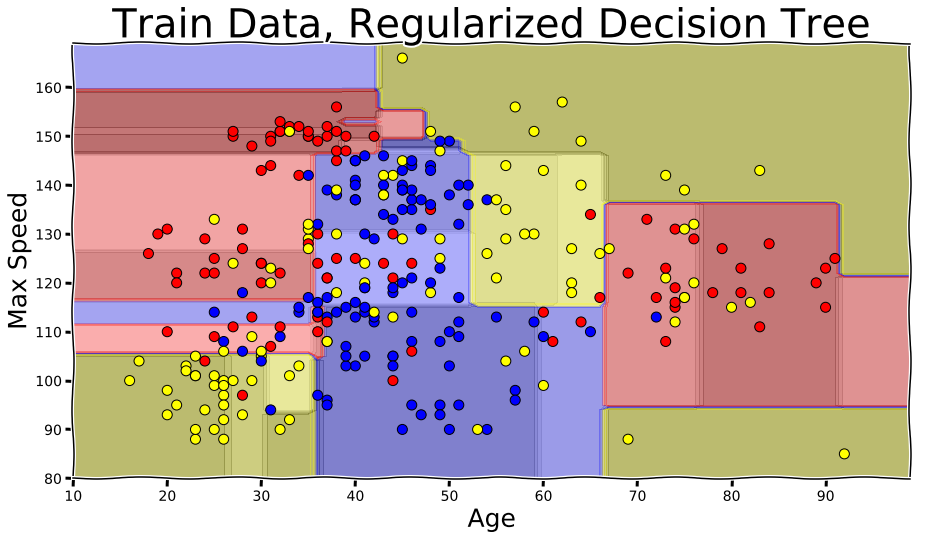

In [0]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Decision Tree")

In [0]:
clf.score(X_test_2_dim, y_test)

0.6566666666666666

In [0]:
scores = cross_val_score(clf, X_train_2_dim, y_train, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.70 (+/- 0.06)


## Ensemble Methods on Decision Trees

* Decision Trees in particular have nice properties, but tend to overfit
* We fight overfitting in decision trees with some success
* However, inherent to their nature, decision trees tend to overfit
* Combining more than one classifier is called an "emsemble method"
* Results from individual will be either averaged, majorty, or boosted by others 

### Bagging
* train a number of estimators using only a subset of your data (https://youtu.be/Cn7StaXU_8o)


## Random Forest
* Random Forest is an ensemble technique that trains a number of simple decision trees and uses a majority vote over all of them for prediction
* like Bagging but with additional random selection of features
* Typically uses average of median for regression
* While each decision tree still overfits using many of them softens this problems
* You still need to regularize the underlying decision trees
* sklearn has a default of 10 decision trees for random forest

_Random Forest sometimes is called the swiss army knife of machine learning_

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 29.4 ms, sys: 0 ns, total: 29.4 ms
Wall time: 108 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
clf.score(X_train_2_dim, y_train)

0.9266666666666666

(<matplotlib.axes._subplots.AxesSubplot at 0x7f16c9dd02b0>,
 <matplotlib.collections.PathCollection at 0x7f16c9cd1ba8>)

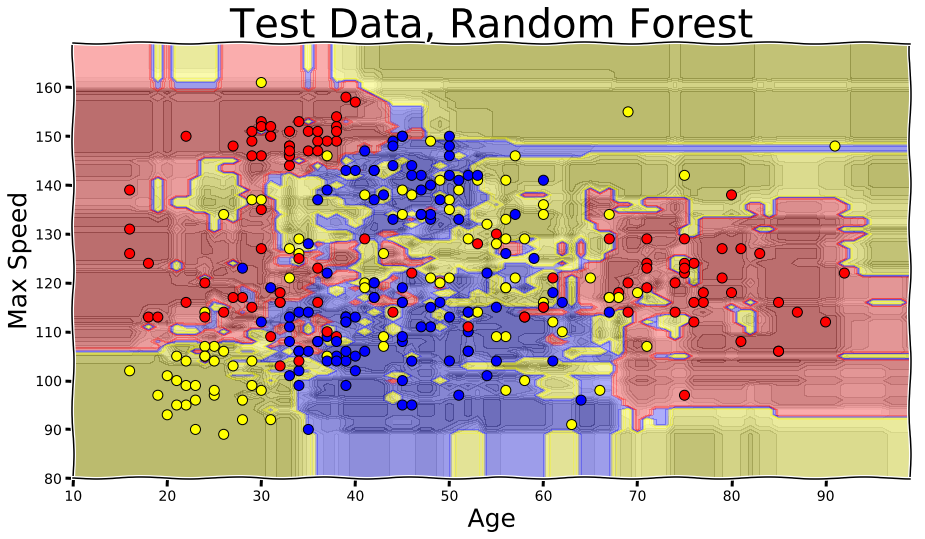

In [0]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Random Forest")

In [0]:
clf.score(X_test_2_dim, y_test)

0.61

## Random Search

Unfortunately, training random forest classifiers is more expensive than decision trees by the number of estimators it uses (10 in our case). This often  makes using a deterministic grid search over all parameters prohibitively expensive even when you can parallelize over many CPUs. We instead use a randomized search, that tries a number of different combinations and we hope to find the best here.

http://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search


In [0]:
# brute force grid search is far too expensive

param_grid = {
    'n_estimators': list(range(3,20)),
    'max_depth': list(range(2, 25)),
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 11))
}
clf = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1)
# %time clf.fit(X_train_2_dim, y_train)
# clf.best_params_

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(3,20),
    "max_depth": randint(2, 25),
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 11)
}

clf = RandomizedSearchCV(RandomForestClassifier(), param_dist, n_iter=1000, n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)
clf.best_params_

CPU times: user 3.66 s, sys: 46.8 ms, total: 3.71 s
Wall time: 35.3 s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 14,
 'min_samples_leaf': 6,
 'min_samples_split': 3,
 'n_estimators': 9}

In [0]:
# parameters found might vary a bit with each run, because it is a random search
clf = RandomForestClassifier(max_depth=9, min_samples_leaf=9, min_samples_split=3, n_estimators=7, n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 21.2 ms, sys: 2.91 ms, total: 24.1 ms
Wall time: 117 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=7, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
clf.score(X_train_2_dim, y_train)

0.7433333333333333

(<matplotlib.axes._subplots.AxesSubplot at 0x7f16c99ea550>,
 <matplotlib.collections.PathCollection at 0x7f16c8cc8f28>)

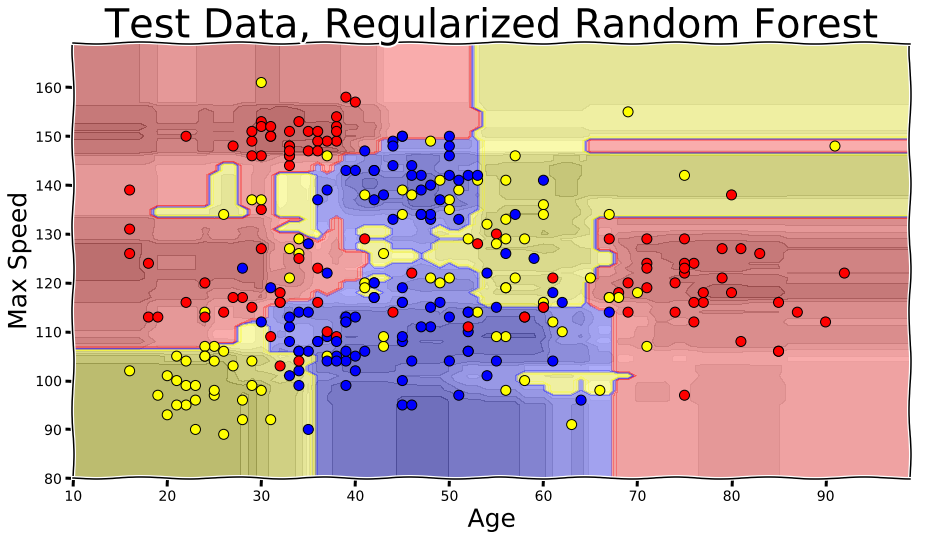

In [0]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Random Forest")

In [0]:
clf.score(X_test_2_dim, y_test)

0.7033333333333334

# Exercise: Try to optimize on the parameters
* we only have a good guess about the optimal parameters here
* re-run the ramdomized search and try to get better results
* you can also try the grid seach with a limited search range 

## AdaBoost

* begins by fitting a classifier on the original dataset
* draws random samples from the training data 
* then fits additional copies of the classifier on the same dataset
* incorrectly classified samples are more likely to be used in subsequent classifiers 
* as a consequence subsequent classifiers focus more on difficult cases
* classifiers are combined like in other ensemble methods

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

<br>
<Img src='https://github.com/djcordhose/ml-workshop/blob/master/notebooks/classic/img/boosting.jpg?raw=1' height=300>
  
Taken from this clear and concise explanation video: https://youtu.be/GM3CDQfQ4sw

In [0]:
from sklearn.ensemble import AdaBoostClassifier
# due to its nature can not run in parallel
clf = AdaBoostClassifier()
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 80.1 ms, sys: 2.34 ms, total: 82.4 ms
Wall time: 84.6 ms


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [0]:
clf.score(X_train_2_dim, y_train)

0.6941666666666667

(<matplotlib.axes._subplots.AxesSubplot at 0x7f16c9a012e8>,
 <matplotlib.collections.PathCollection at 0x7f16c8ccf240>)

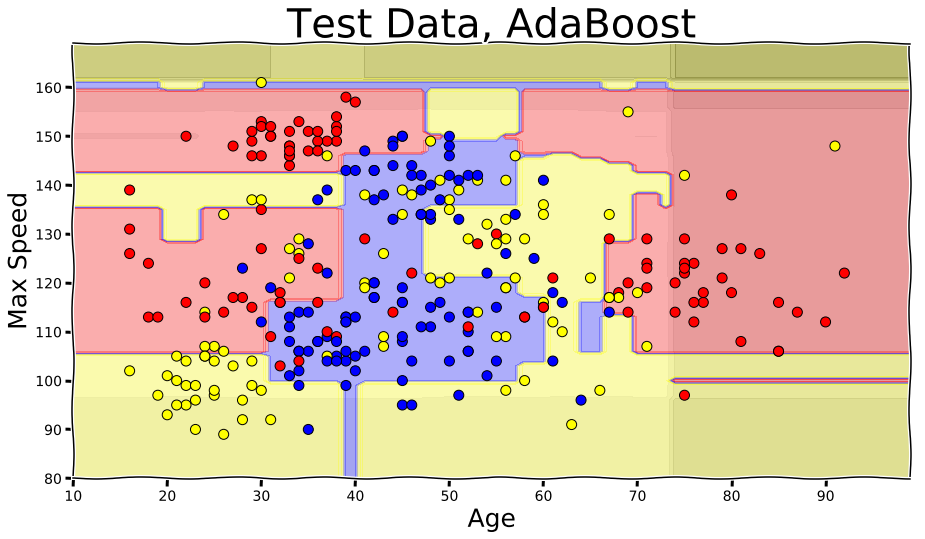

In [0]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, AdaBoost")

In [0]:
clf.score(X_test_2_dim, y_test)

0.6466666666666666